In [222]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_density import KDEMultivariate
# from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedGroupKFold
import seaborn as sns
import numpy as np
import re
import os


In [174]:
%load_ext autoreload
%autoreload 2
    
from helpers.utils import _qq_stats_text
from helpers.utils import scree
from helpers.utils import learn_kde
from helpers.utils import score_with_kdes
from helpers.utils import reshape_to_cmat, _site_slice
import helpers.utils 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
import sys; print(sys.executable)

plt.rcParams.update({"font.size": 9})

/Users/gc3045/miniconda3/bin/python


In [176]:
plot_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/"
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"

barcoded_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/barcoded_tracing_alleles.csv"
colony_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/colony_alleles.csv"
validation_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/preedited_merfish_invitro_alleles.csv"

In [177]:
codebook_fname = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/PEtracer raw data/edit_codebook.csv"

First look at the `preedited_merfish_invitro_alleles.csv`. For each cassette, we have three target sites. The features are in columns: r25-r51. First, I need to extract these features and then rotate them to long format, so that I have a row for every (cellBC, intID, target_site). Note that the order of target sites is: `RNF2, HEK3, EMX1` in the paper, but we let the order be `HEK3`, `EMX1`, `RNF2` according to the order given in `validation_df`. This was also checked using classification error. 

Recall that NaN is the unedited state!

#### Process inputs

In [178]:
validation_df = pd.read_csv(validation_fname)
codebook = pd.read_csv(codebook_fname)

In [179]:
dfw = validation_df.copy().fillna("unedited")
codebook_df = codebook.copy().fillna("unedited")

In [180]:
codebook_df

,site,edit,bit
0,HEK3,GATAG,r25
1,HEK3,AATCG,r26
2,HEK3,GCAAG,r27
3,HEK3,GCGCC,r28
4,HEK3,CTTTG,r29
5,HEK3,ATCAA,r30
6,HEK3,CTCTC,r31
7,HEK3,ATTTA,r32
8,EMX1,GGACA,r33
9,EMX1,ACAAT,r34


In [181]:
dfw

,intID,cellBC,HEK3,EMX1,RNF2,spot,x,y,z,global_x,...,cell_dist,sample,clone,whitelist,RNF2_actual,HEK3_actual,EMX1_actual,RNF2_brightest,HEK3_brightest,EMX1_brightest
0,intID1011,4T1_preedited-1057,CTCTC,AGTAC,ACTCC,226,504,123,20,-765.072,...,0.139511,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
1,intID1011,4T1_preedited-1120,CTCTC,AGTAC,ACTCC,42,1928,1712,26,-612.704,...,1.070000,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
2,intID1011,4T1_preedited-1143,CTCTC,AGTAC,ACTCC,105,1951,952,31,-610.243,...,0.348657,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
3,intID1011,4T1_preedited-1153,CTCTC,AGTAC,ACTCC,191,2189,647,23,-584.777,...,1.533115,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
4,intID1011,4T1_preedited-1162,CTCTC,AGTAC,ACTCC,11,1944,1198,6,-610.992,...,3.000000,4T1_preedited,2,True,ACTCC,CTCTC,AGTAC,ACTCC,CTCTC,AGTAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43930,intID974,4T1_preedited-8630,GCGCC,ATTCG,TTCCT,631,378,1209,22,1093.446,...,3.472146,4T1_preedited,2,True,TTCCT,GCGCC,ATTCG,TTCCT,GCGCC,ATTCG
43931,intID974,4T1_preedited-8638,GCGCC,ATTCG,TTCCT,158,84,519,31,1061.988,...,2.240381,4T1_preedited,2,True,TTCCT,GCGCC,ATTCG,TTCCT,GCGCC,ATTCG
43932,intID974,4T1_preedited-8639,GCGCC,ATTCG,TTCCT,422,323,533,25,1087.561,...,0.000000,4T1_preedited,2,True,TTCCT,GCGCC,ATTCG,TTCCT,GCGCC,ATTCG
43933,intID974,4T1_preedited-8644,GCGCC,ATTCG,TTCCT,320,431,423,36,1099.117,...,3.177443,4T1_preedited,2,True,TTCCT,GCGCC,ATTCG,TTCCT,GCGCC,ATTCG


In [182]:
dfw['clone'].value_counts()

clone
1    22473
2    12682
4     5886
3     2894
Name: count, dtype: int64

In [183]:
id_cols    = ["cellBC", "intID", "clone"]
site_cols  = ["HEK3", "EMX1", "RNF2"]
actual_cols    = [f"{s}_actual"    for s in site_cols]   # sequencing ground truth
brightest_cols = [f"{s}_brightest" for s in site_cols]   # brightest call
prob_cols      = [f"{s}_prob"      for s in site_cols]   # per-site probability (PETRacer)

rcols = [c for c in dfw.columns if re.fullmatch(r"r(?:2[5-9]|3\d|4\d|5[01])", c)]
rcols_sorted = sorted(rcols, key=lambda s: int(s[1:]))

In [184]:
assert set(site_cols).issubset(dfw.columns), "Missing site columns"
assert all(c in dfw.columns for c in actual_cols), "Missing *_actual"
assert all(c in dfw.columns for c in brightest_cols), "Missing *_brightest"
assert all(c in dfw.columns for c in prob_cols), "Missing *_prob"
assert len(rcols_sorted) == 27, f"Expected 27 r-features, found {len(rcols_sorted)}"

In [185]:
pieces = [
    _site_slice(dfw, "HEK3", id_cols, codebook_df),
    _site_slice(dfw, "EMX1", id_cols, codebook_df),
    _site_slice(dfw, "RNF2", id_cols, codebook_df),
]
long_df = pd.concat(pieces, axis=0, ignore_index=True)

In [186]:
assert long_df.shape[0] == (validation_df.shape[0] * 3)

In [189]:
feature_cols = [f"feature_{j}" for j in range(9)]
len(feature_cols)

9

In [190]:
truth = long_df["seq_state"]
pet   = long_df["pet_state"]
brite = long_df["brightest_state"]

mask_pet   = truth.notna() & pet.notna()
mask_brite = truth.notna() & brite.notna()

pet_wrong_pct   = 100 * (pet[mask_pet] != truth[mask_pet]).mean()
brite_wrong_pct = 100 * (brite[mask_brite] != truth[mask_brite]).mean()

print(f"PETRacer discriminative classifier is wrong: {pet_wrong_pct:.3f}% of the time (n={int(mask_pet.sum())})")
print(f"Brightest fluorescence is wrong: {brite_wrong_pct:.3f}% of the time (n={int(mask_brite.sum())})")

PETRacer discriminative classifier is wrong: 1.783% of the time (n=131805)
Brightest fluorescence is wrong: 2.261% of the time (n=131805)


In [191]:
long_df['clone'].unique()

array([2, 1, 4, 3])

In [245]:
long_df

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,feature_4_bit,feature_4_edit,feature_5_bit,feature_5_edit,feature_6_bit,feature_6_edit,feature_7_bit,feature_7_edit,feature_8_bit,feature_8_edit
0,4T1_preedited-1057,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999968,217.510,217.293,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
1,4T1_preedited-1120,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.998348,381.193,1051.053,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
2,4T1_preedited-1143,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999994,447.105,514.259,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
4,4T1_preedited-1162,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999808,1261.121,1508.173,...,r29,CTTTG,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131800,4T1_preedited-8630,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999471,218.098,139.293,...,r45,GTTCA,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited
131801,4T1_preedited-8638,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999980,634.978,184.150,...,r45,GTTCA,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited
131802,4T1_preedited-8639,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.991395,241.436,182.970,...,r45,GTTCA,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited
131803,4T1_preedited-8644,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999988,293.748,168.804,...,r45,GTTCA,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited


In [246]:
unique_cassettes = long_df['intID'].unique()
cassette_mapping = {id_: i for i, id_ in enumerate(unique_cassettes)}
long_df["cassette_idx"] = long_df["intID"].map(cassette_mapping)

site_mapping = {'RNF2': 0, 'HEK3': 1, 'EMX1': 2}
long_df['target_idx'] = long_df['target_site'].map(site_mapping) + len(site_mapping) * long_df["cassette_idx"]

To-do: (Reproducing Figure 2 from the paper)
- ~~Look at the non-parametric nature of the data~~
- ~~Z-normalize and compute scree plot.~~
- ~~Split 70/30 train/test. Train 27 KDEs.~~
- ~~Report classification error.~~
- ~~Split into Clone 2 (most sites). Score test samples.~~
- ~~Run LAML-Pro.~~
- ~~Plot logdensity convergence.~~
- Report genotype call accuracy vs. genotype sequencing accuracy.
- Look at alignment distance vs. genotype call accuracy. 
- Look at places where the "brightest" intensity pixel was not the correct state.

In [247]:
long_df

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,feature_5_bit,feature_5_edit,feature_6_bit,feature_6_edit,feature_7_bit,feature_7_edit,feature_8_bit,feature_8_edit,cassette_idx,target_idx
0,4T1_preedited-1057,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999968,217.510,217.293,...,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited,0,1
1,4T1_preedited-1120,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.998348,381.193,1051.053,...,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited,0,1
2,4T1_preedited-1143,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999994,447.105,514.259,...,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited,0,1
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited,0,1
4,4T1_preedited-1162,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999808,1261.121,1508.173,...,r30,ATCAA,r31,CTCTC,r32,ATTTA,r50,unedited,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131800,4T1_preedited-8630,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999471,218.098,139.293,...,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited,31,93
131801,4T1_preedited-8638,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999980,634.978,184.150,...,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited,31,93
131802,4T1_preedited-8639,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.991395,241.436,182.970,...,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited,31,93
131803,4T1_preedited-8644,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999988,293.748,168.804,...,r46,TGCCA,r47,TCCAA,r48,ACTCC,r51,unedited,31,93


In [276]:
site_states = (
    long_df[['target_site', 'seq_state']]
    .drop_duplicates()
    .groupby('target_site')['seq_state']
    .apply(list)
)

In [277]:
# save a codebook
rows = []
for site, labels in site_states.items():
    # ensure 'unedited' is 0, others get 1..8 sorted alphabetically
    labels_sorted = sorted([l for l in labels if l != "unedited"])
    ordered = ["unedited"] + labels_sorted
    for i, lbl in enumerate(ordered):
        rows.append({"site": site, "label": lbl, "genotype": i})

label_codebook = pd.DataFrame(rows).sort_values(["site", "genotype"], ignore_index=True)

In [278]:
label_codebook

,site,label,genotype
0,EMX1,unedited,0
1,EMX1,ACAAT,1
2,EMX1,AGTAC,2
3,EMX1,ATCAA,3
4,EMX1,ATTCG,4
5,EMX1,CCCTA,5
6,EMX1,CCGAT,6
7,EMX1,CCTTT,7
8,EMX1,GGACA,8
9,HEK3,unedited,0


In [333]:
label_codebook.to_csv(out_dir + "/label_codebook.csv", index=False) 

In [281]:
for col in ['seq', 'brightest', 'pet']:
    long_df = long_df.merge(
        label_codebook.rename(columns={'site': 'target_site', 'label': f'{col}_state', 'genotype': f'{col}_geno'}),
        on=['target_site', f'{col}_state'],
        how='left'
    )

In [282]:
long_df

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,feature_6_edit,feature_7_bit,feature_7_edit,feature_8_bit,feature_8_edit,cassette_idx,target_idx,seq_geno,brightest_geno,pet_geno
0,4T1_preedited-1057,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999968,217.510,217.293,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
1,4T1_preedited-1120,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.998348,381.193,1051.053,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
2,4T1_preedited-1143,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999994,447.105,514.259,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
4,4T1_preedited-1162,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999808,1261.121,1508.173,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131800,4T1_preedited-8630,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999471,218.098,139.293,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131801,4T1_preedited-8638,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999980,634.978,184.150,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131802,4T1_preedited-8639,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.991395,241.436,182.970,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131803,4T1_preedited-8644,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999988,293.748,168.804,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8


#### Evaluate non-parametric nature of the data

In [248]:
df = long_df

In [249]:
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/plots/petracer_nonparametric/"

In [250]:
site_scalers = dict()
scaled_site_data = dict()
for site in df['target_site'].unique():
    mask = df['target_site'] == site
    sub_df = df.loc[mask]
    scaler = StandardScaler()
    X = scaler.fit_transform(sub_df[feature_cols].values)   
    scaled_site_data[site] = pd.DataFrame(X)

In [251]:
site_scalers = dict()
scaled_site_data = dict()

for site in df["target_site"].dropna().unique():
    mask = df['target_site'] == site
    sub_df = df.loc[mask]
    
    scaler = StandardScaler()
    
    X_scaled = scaler.fit_transform(sub_df[feature_cols].values)   
    
    site_scalers[site] = scaler
    scaled_site_data[site] = X
    
    labels = sub_df["seq_state"].unique()

    for lab in labels:
        m = sub_df["seq_state"].eq(lab)       
        idx = m.to_numpy()
        Z = X_scaled[idx, :]                               
        if Z.shape[0] == 0:
            continue

        # 3x3 grid for 9 features
        fig, axes = plt.subplots(3, 3, figsize=(10, 9), dpi=150)
        axes = axes.ravel()

        for j in range(9):
            ax = axes[j]
            stats.probplot(Z[:, j], dist="norm", plot=ax)
            ax.set_title(feature_cols[j], fontsize=9)
            ax.set_xlabel(""); ax.set_ylabel("")
            # If you have this helper already:
            try:
                ax.text(0.02, 0.98, _qq_stats_text(Z[:, j]),
                        transform=ax.transAxes, fontsize=8, family="monospace",
                        va="top", ha="left")
            except NameError:
                pass  # skip annotation if helper not defined

        # Hide any remaining axes (paranoia; should be none for 9 features)
        for k in range(9, len(axes)):
            axes[k].axis("off")

        fig.suptitle(f"QQ plots (z-norm) — site={site}, label={lab} (n={Z.shape[0]})",
                     fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        safe_lab = re.sub(r"[^A-Za-z0-9._-]+", "_", str(lab))
        pdf = os.path.join(out_dir, f"qq_site_{site}_{safe_lab}.pdf")
        fig.savefig(pdf, bbox_inches="tight")
        plt.close(fig)

#### Intrinsic dimensionality of data

In [203]:
df = long_df.copy()

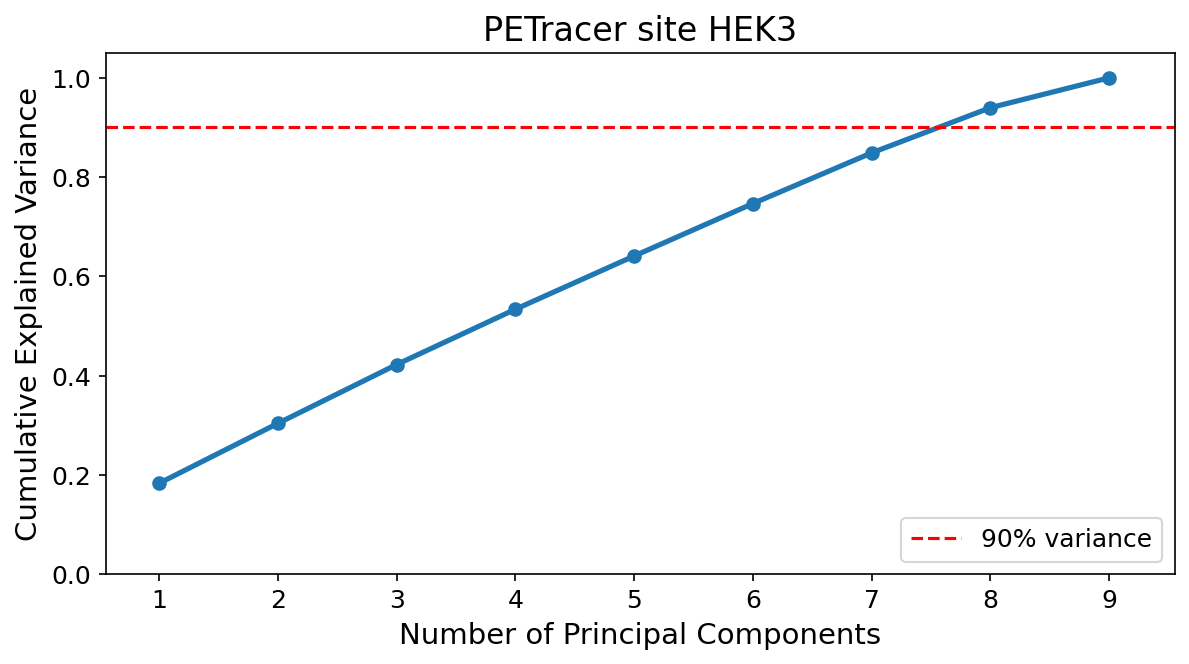

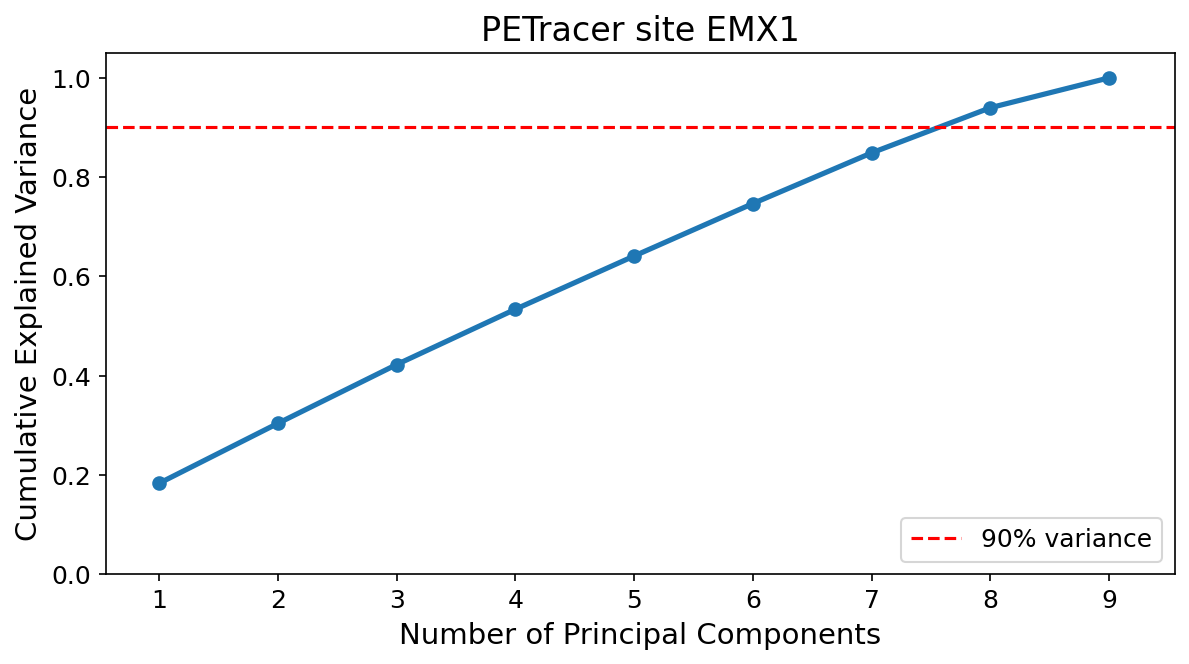

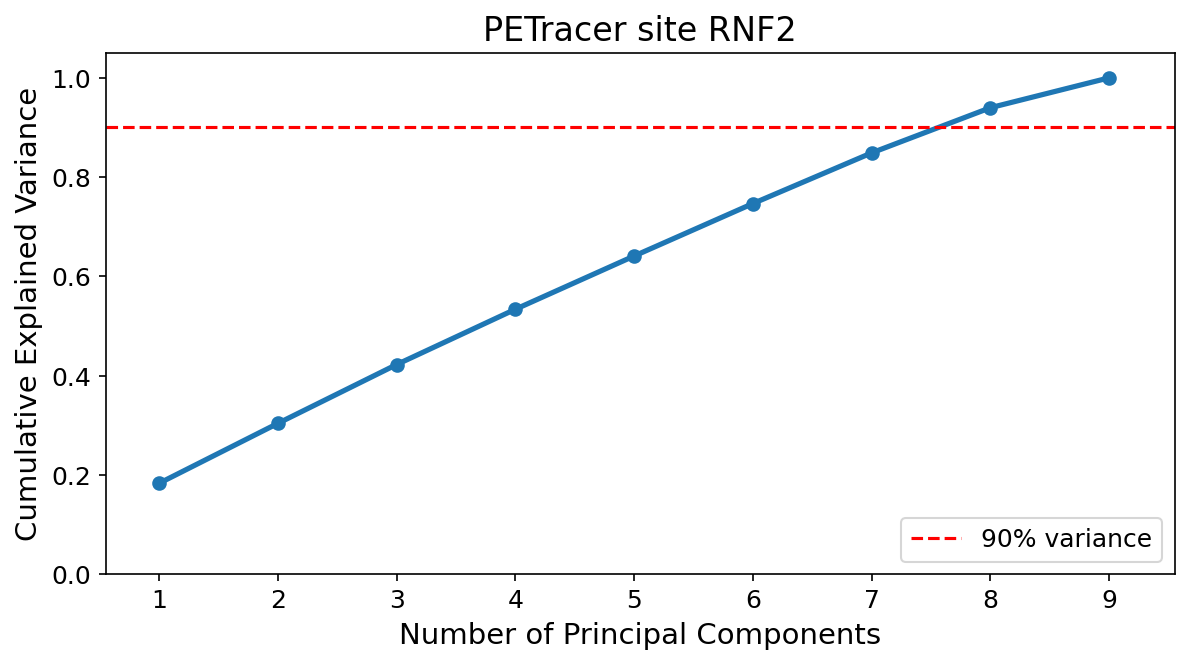

In [205]:
site_scalers = dict()
# scaled_site_data = dict()

for site in df['target_site'].unique():

    scaler = StandardScaler()
    X_train = scaler.fit_transform(df[feature_cols].values)
    site_scalers[site] = scaler
    
    vr, cv = scree(X_train, out=f"{plot_dir}/PEtracer_scree_{site}_full.pdf", title=f"PETracer site {site}")

In [216]:
from sklearn.model_selection import StratifiedGroupKFold

In [218]:
y = df["seq_state"]
groups = df["cellBC"]
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
train_idx, test_idx = next(sgkf.split(X=df, y=y, groups=groups))

In [220]:
df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# Sanity checks
assert set(df_train["cellBC"]).isdisjoint(df_test["cellBC"])
print(df_train["seq_state"].value_counts(normalize=True).round(3))
print(df_test["seq_state"].value_counts(normalize=True).round(3))

seq_state
unedited    0.203
CTTTG       0.082
ATCAA       0.075
TTCCT       0.067
ACAAT       0.060
CCTTT       0.048
TCCAA       0.046
GGACA       0.046
GATAG       0.042
CTCTC       0.041
AGTAC       0.041
ACAGT       0.039
GCAAG       0.031
ACTCC       0.031
CCCTA       0.031
TGCCA       0.027
TATAT       0.026
ACTTA       0.020
GCGCC       0.010
AATCG       0.010
GTTCA       0.009
ATTCG       0.005
ATTTA       0.005
CCGAT       0.004
Name: proportion, dtype: float64
seq_state
unedited    0.185
CTTTG       0.083
ATCAA       0.076
TTCCT       0.070
ACAAT       0.060
CCTTT       0.048
GGACA       0.048
TCCAA       0.045
AGTAC       0.043
CTCTC       0.043
GATAG       0.041
ACAGT       0.040
ACTCC       0.032
GCAAG       0.032
CCCTA       0.031
TGCCA       0.026
TATAT       0.026
ACTTA       0.022
AATCG       0.011
GCGCC       0.011
GTTCA       0.010
ATTCG       0.005
ATTTA       0.005
CCGAT       0.005
Name: proportion, dtype: float64


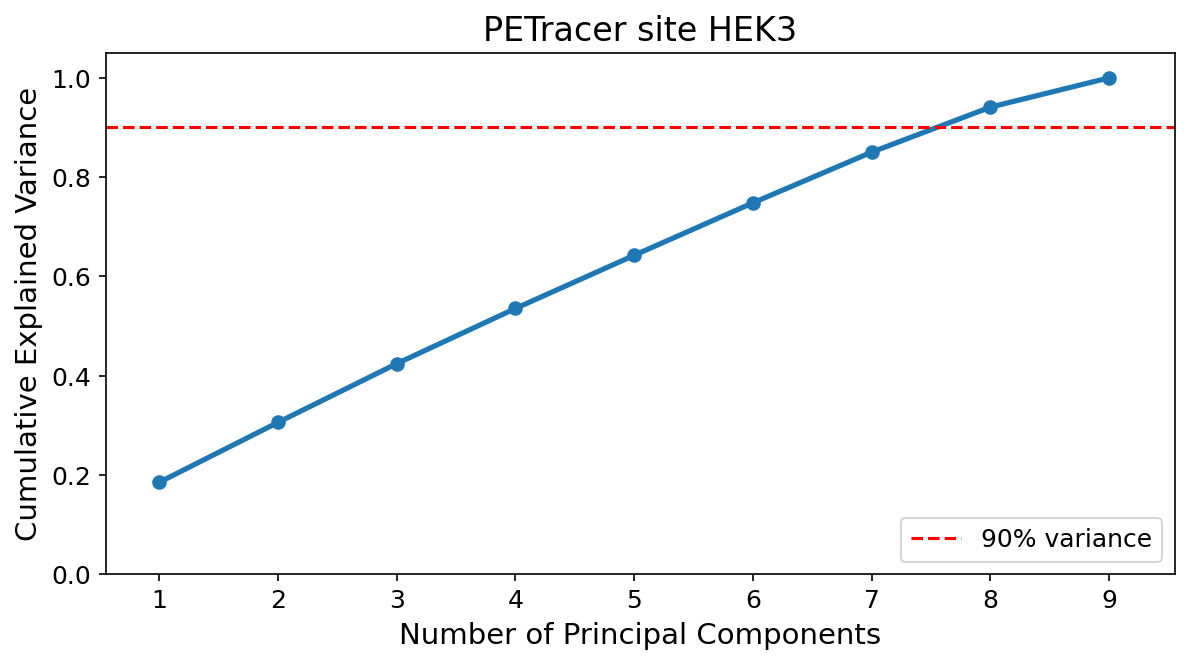

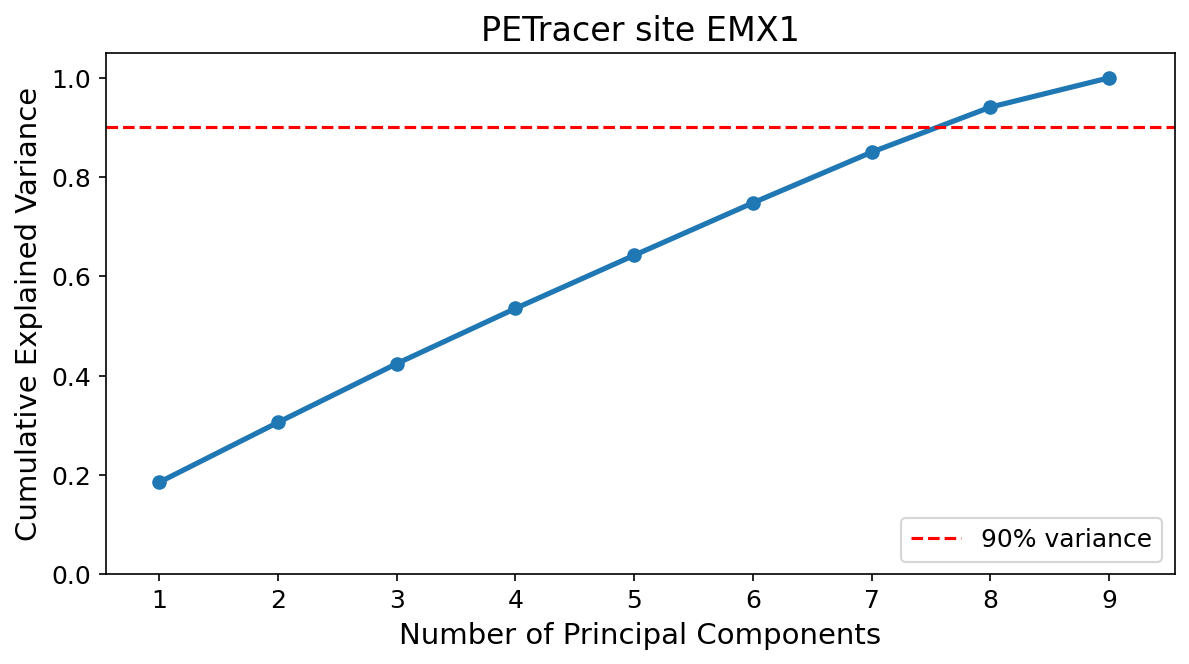

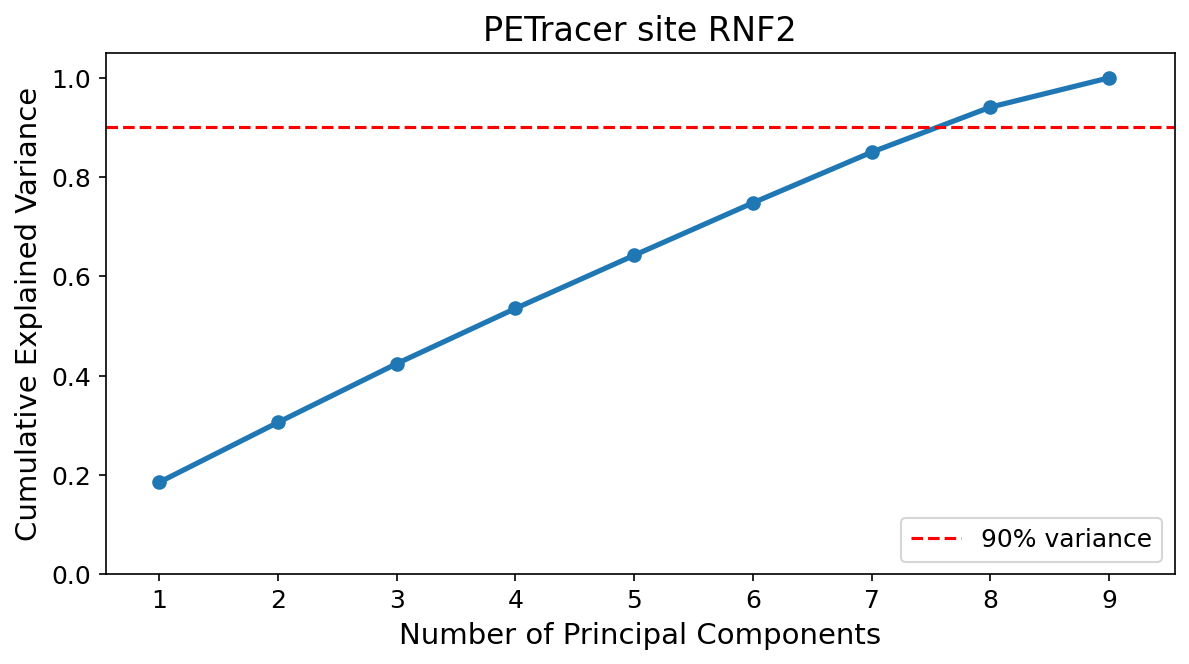

In [221]:
site_scalers = dict()
# scaled_site_data = dict()

for site in df['target_site'].unique():

    scaler = StandardScaler()
    X_train = scaler.fit_transform(df_train[feature_cols].values)
    site_scalers[site] = scaler
    
    vr, cv = scree(X_train, out=f"{plot_dir}/PEtracer_scree_{site}_train.pdf", title=f"PETracer site {site}")

In [208]:
df_train['clone'].value_counts(normalize=True)

clone
1    0.512037
2    0.291175
4    0.132614
3    0.064174
Name: proportion, dtype: float64

In [209]:
df_test['clone'].value_counts(normalize=True)

clone
1    0.510240
2    0.282646
4    0.137204
3    0.069911
Name: proportion, dtype: float64

#### Check if the features are correlated

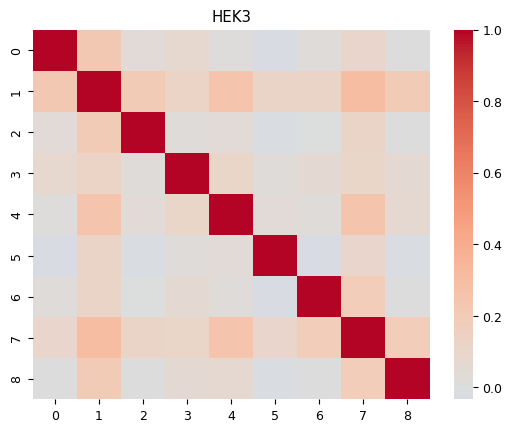

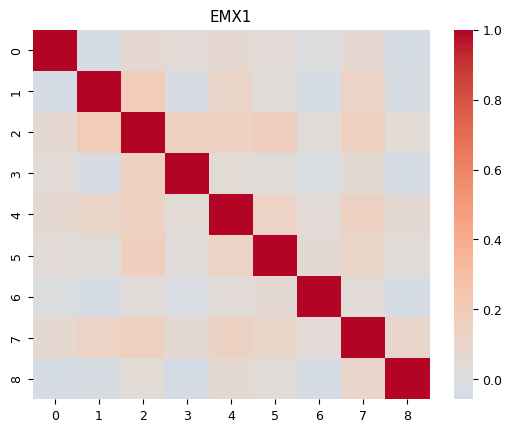

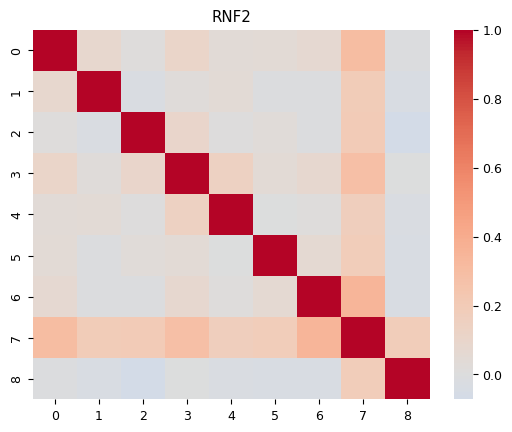

In [210]:
sites = df_train['target_site'].unique()
for site in sites:
    mask = df_train['target_site'] == site
    site_df = df_train.loc[mask]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(site_df[feature_cols].values.copy())
    X_test = scaler.transform(site_df[feature_cols].values.copy())

    corr = pd.DataFrame(X_train).corr(numeric_only=True)
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title(site)
    plt.show()

#### Evaluate z-norm or pca rotation of data

In [223]:
df = long_df.copy()

In [226]:
y = df["seq_state"]
groups = df["cellBC"]
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
train_idx, test_idx = next(sgkf.split(X=df, y=y, groups=groups))

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

In [228]:
# Sanity checks
states = sorted(set(df_train["seq_state"]) | set(df_test["seq_state"]))
props = pd.DataFrame({
    "train_prop": df_train["seq_state"].value_counts(normalize=True),
    "test_prop":  df_test["seq_state"].value_counts(normalize=True),
}).reindex(states).fillna(0).round(3)
props

,train_prop,test_prop
seq_state,,
AATCG,0.010,0.011
ACAAT,0.060,0.060
ACAGT,0.039,0.040
ACTCC,0.031,0.032
ACTTA,0.020,0.022
AGTAC,0.041,0.043
ATCAA,0.075,0.076
ATTCG,0.005,0.005
ATTTA,0.005,0.005


In [229]:
site_scalers = dict()
X_site_train_data = dict()
Z_site_train_data = dict()

sites = df_train['target_site'].unique()
all_kde_dict_X, all_kde_dict_Z = {}, {}

for site in sites:
    mask = df_train['target_site'] == site
    site_df = df_train.loc[mask]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(site_df[feature_cols].values.copy())

    site_scalers[site] = scaler
    X_site_train_data[site] = X_train
    
    pca = PCA(n_components=9, random_state=0, svd_solver='full', whiten=False)
    Z_train = pca.fit_transform(X_train.copy())
    Z_site_train_data[site] = Z_train

    all_kde_dict_X[site] = {}
    all_kde_dict_Z[site] = {}
    labels = site_df["seq_state"].unique()

    for lab in labels:
        m_train = site_df["seq_state"].eq(lab)   # boolean mask over df_train rows
        n = int(m_train.sum())
        if n < min_pts:
            continue

        X_block = X_train[m_train.values, :]   # raw feature space (scaled)
        Z_block = Z_train[m_train.values, :]   # PCA space

        kde_X = learn_kde(X_block)
        print(f"{site} {lab} [n={n}] kde(X) IMSE={kde_X.imse(kde_X.bw):.4g}")
        all_kde_dict_X[site][lab] = kde_X

        kde_Z = learn_kde(Z_block)
        print(f"{site} {lab} [n={n}] kde(Z) IMSE={kde_Z.imse(kde_Z.bw):.4g}")
        all_kde_dict_Z[site][lab] = kde_Z


HEK3 CTCTC [n=4345] kde(X) IMSE=-851.1
HEK3 CTCTC [n=4345] kde(Z) IMSE=-4.334
HEK3 CTTTG [n=8652] kde(X) IMSE=-956.1
HEK3 CTTTG [n=8652] kde(Z) IMSE=-63.67
HEK3 ATCAA [n=4592] kde(X) IMSE=-169.7
HEK3 ATCAA [n=4592] kde(Z) IMSE=-2.022
HEK3 unedited [n=7127] kde(X) IMSE=-876
HEK3 unedited [n=7127] kde(Z) IMSE=-19.26
HEK3 GATAG [n=4404] kde(X) IMSE=-290.8
HEK3 GATAG [n=4404] kde(Z) IMSE=-1.288
HEK3 AATCG [n=1026] kde(X) IMSE=-158.3
HEK3 AATCG [n=1026] kde(Z) IMSE=-0.4544
HEK3 GCAAG [n=3305] kde(X) IMSE=-915
HEK3 GCAAG [n=3305] kde(Z) IMSE=-0.4922
HEK3 ATTTA [n=505] kde(X) IMSE=-67.46
HEK3 ATTTA [n=505] kde(Z) IMSE=-0.01507
HEK3 GCGCC [n=1067] kde(X) IMSE=-68.18
HEK3 GCGCC [n=1067] kde(Z) IMSE=-0.1145
EMX1 AGTAC [n=4259] kde(X) IMSE=-2129
EMX1 AGTAC [n=4259] kde(Z) IMSE=-1.311
EMX1 ACAAT [n=6263] kde(X) IMSE=-668.9
EMX1 ACAAT [n=6263] kde(Z) IMSE=-5.009
EMX1 CCTTT [n=5093] kde(X) IMSE=-1783
EMX1 CCTTT [n=5093] kde(Z) IMSE=-20.44
EMX1 unedited [n=7127] kde(X) IMSE=-2087
EMX1 unedited [n=712

In [230]:
# check the bandwidths
for label in all_kde_dict_X['HEK3']:
    print("HEK3", label, all_kde_dict_X['HEK3'][label].bw)    
for label in all_kde_dict_X['EMX1']:
    print("EMX1", label, all_kde_dict_X['EMX1'][label].bw)
for label in all_kde_dict_X['RNF2']:
    print('RNF2', label, all_kde_dict_X['RNF2'][label].bw)

HEK3 CTCTC [0.06540799 0.27434339 0.09484413 0.12936169 0.13737553 0.01794076
 1.18430181 0.32750733 0.10282097]
HEK3 CTTTG [0.0663621  0.26585165 0.08938214 0.15362316 0.85853319 0.05362051
 0.08493197 0.26092827 0.11334111]
HEK3 ATCAA [0.07661101 0.31704001 0.08598057 0.14592327 0.16138429 1.14573754
 0.09874256 0.27297737 0.11458347]
HEK3 unedited [0.06985195 0.28070736 0.09673572 0.17465334 0.15353211 0.02712071
 0.09379544 0.24961169 0.93186763]
HEK3 GATAG [1.18554012 0.3982283  0.13959383 0.19014798 0.13448826 0.02304263
 0.0984493  0.23917134 0.10729167]
HEK3 AATCG [0.08336877 2.42449675 0.33006835 0.23571215 0.18353092 0.02063757
 0.12195438 0.32646607 0.11828207]
HEK3 GCAAG [0.07858318 0.30866635 1.46179227 0.10160574 0.15617931 0.0278042
 0.11136834 0.26121249 0.12341883]
HEK3 ATTTA [0.10836866 0.40145681 0.1503198  0.16361105 0.20420474 0.05010945
 0.14357574 3.62814452 0.15979852]
HEK3 GCGCC [0.07392761 0.3059232  0.09691525 2.56536295 0.25501242 0.0940936
 0.13967806 0.278

#### Evaluate classification accuracy

Try splitting into sites before Z-normalizing (and PCA rotating).

In [284]:
df = long_df.copy()

In [285]:
df

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,feature_6_edit,feature_7_bit,feature_7_edit,feature_8_bit,feature_8_edit,cassette_idx,target_idx,seq_geno,brightest_geno,pet_geno
0,4T1_preedited-1057,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999968,217.510,217.293,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
1,4T1_preedited-1120,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.998348,381.193,1051.053,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
2,4T1_preedited-1143,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999994,447.105,514.259,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
4,4T1_preedited-1162,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999808,1261.121,1508.173,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131800,4T1_preedited-8630,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999471,218.098,139.293,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131801,4T1_preedited-8638,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999980,634.978,184.150,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131802,4T1_preedited-8639,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.991395,241.436,182.970,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131803,4T1_preedited-8644,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999988,293.748,168.804,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8


In [286]:
y = df["seq_state"]
groups = df["cellBC"]
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)
train_idx, test_idx = next(sgkf.split(X=df, y=y, groups=groups))
df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

#### Sanity check df_test split

In [287]:
df_test

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,feature_6_edit,feature_7_bit,feature_7_edit,feature_8_bit,feature_8_edit,cassette_idx,target_idx,seq_geno,brightest_geno,pet_geno
1,4T1_preedited-1120,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.998348,381.193,1051.053,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
8,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
13,4T1_preedited-1260,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999758,165.879,187.516,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
17,4T1_preedited-1281,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999984,403.163,342.035,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
20,4T1_preedited-1290,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.907947,172.470,309.039,...,CTCTC,r32,ATTTA,r50,unedited,0,1,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131789,4T1_preedited-8534,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999998,387.103,144.015,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131793,4T1_preedited-8569,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999043,141.643,160.541,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131795,4T1_preedited-8598,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999999,272.823,134.571,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8
131800,4T1_preedited-8630,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999471,218.098,139.293,...,TCCAA,r48,ACTCC,r51,unedited,31,93,8,8,8


In [288]:
print(df_train.loc[df_train['clone'] == 2, 'cellBC'].nunique())
print(df_test.loc[df_test['clone'] == 2, 'cellBC'].nunique())

632
176


In [300]:
lm_colors = {
    1: '#A52A2A',   # dark red
    2: '#D2691E',   # orange-brown
    3: '#FFD700',   # yellow
    4: '#9ACD32',   # yellow-green
    5: '#4682B4',   # blue
    6: '#00008B',   # dark blue
    7: '#9370DB',   # purple
    8: '#800080',   # deep purple
    0:  '#C0C0C0',    # light gray (unedited)
    -1:  '#E0E0E0'     # very light gray (not detected)
}

In [313]:
sub = df_test[['cellBC', 'target_idx', 'seq_geno']] # .loc[df_test['clone'] == 2, ['cellBC', 'target_idx', 'pet_state']]
mat = sub.pivot(index='cellBC', columns='target_idx', values='seq_geno').fillna(-1).astype('Int64')

/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/gc3045/miniconda3/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


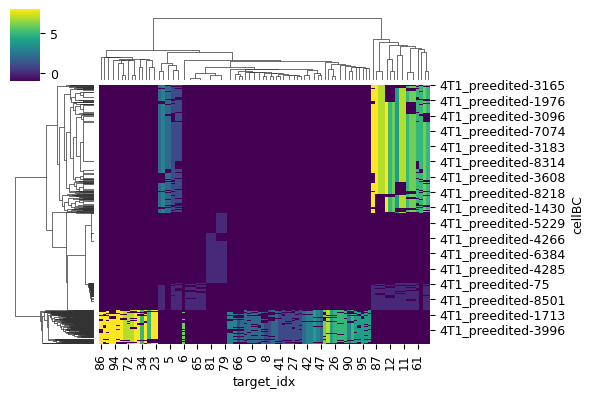

In [314]:
mat_num = mat.fillna(-1).astype(int)
sns.clustermap(mat_num, cmap='viridis', figsize=(6,4))
plt.show()

#### make predictions

In [315]:
site_scalers = dict()
site_rotates = dict()
X_site_train_data, X_site_test_data = dict(), dict()
Z_site_train_data, Z_site_test_data = dict(), dict()

sites = df_train['target_site'].unique()
all_kde_dict_X, all_kde_dict_Z = {}, {}

preds_X_full = pd.DataFrame(index=df_test.index, columns=["pred_label","argmax_idx","argmax_logpdf"])
preds_Z_full = pd.DataFrame(index=df_test.index, columns=["pred_label","argmax_idx","argmax_logpdf"])
scores_X_tables = []
scores_Z_tables = []

for site in sites:
    print(site)
    mask_train = df_train['target_site'] == site
    site_df_train = df_train.loc[mask_train]
    
    mask_test = df_test['target_site'] == site
    site_df_test = df_test.loc[mask_test]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(site_df_train[feature_cols].values.copy())
    X_test = scaler.transform(site_df_test[feature_cols].values.copy())

    pca = PCA(n_components=9, random_state=0, svd_solver='full', whiten=False)
    Z_train = pca.fit_transform(X_train.copy())
    Z_test  = pca.transform(X_test.copy())

    site_scalers[site] = scaler
    site_rotates[site] = pca
    X_site_train_data[site] = X_train
    X_site_test_data[site] = X_test
    Z_site_train_data[site] = Z_train
    Z_site_test_data[site] = Z_test
    
    all_kde_dict_X[site] = {}
    all_kde_dict_Z[site] = {}
    labels = site_df_train["seq_state"].unique()

    for lab in labels:
        m_train = site_df_train["seq_state"].eq(lab)   # boolean mask over df_train rows
        n = int(m_train.sum())
        if n < min_pts:
            continue

        X_block = X_train[m_train.values, :]   # raw feature space (scaled)
        Z_block = Z_train[m_train.values, :]   # PCA space

        kde_X = learn_kde(X_block)
        all_kde_dict_X[site][lab] = kde_X
        kde_Z = learn_kde(Z_block)
        all_kde_dict_Z[site][lab] = kde_Z

    # test
    pred_cols = ["pred_label","argmax_idx","argmax_logpdf"]
    
    # --- X space ---
    preds_X, scores_X = score_with_kdes(X_test, all_kde_dict_X[site])
    # write predictions into the preallocated frame using the boolean mask
    preds_X_full.loc[mask_test, pred_cols] = preds_X[pred_cols].to_numpy()
    # scores: align to df_test via the site’s original indices, then prefix columns
    scores_X.index = site_df_test.index
    scores_X = scores_X.add_prefix(f"{site}::")
    scores_X_tables.append(scores_X)
    print("Scored X...")
    
    # --- Z space ---
    preds_Z, scores_Z = score_with_kdes(Z_test, all_kde_dict_Z[site])
    preds_Z_full.loc[mask_test, pred_cols] = preds_Z[pred_cols].to_numpy()
    scores_Z.index = site_df_test.index
    scores_Z = scores_Z.add_prefix(f"{site}::")
    scores_Z_tables.append(scores_Z)
    print("Scored Z...")

Scored X...
Scored Z...
Scored X...
Scored Z...
Scored X...
Scored Z...


In [318]:
# Clean types
for df_ in (preds_X_full, preds_Z_full):
    df_["argmax_logpdf"] = pd.to_numeric(df_["argmax_logpdf"], errors="coerce")

# Merge with metadata if you want a single output table
out = (
    df_test[["intID","target_site","seq_state","brightest_state", "pet_state"]]
    .join(preds_X_full.add_prefix("X_"))
    .join(preds_Z_full.add_prefix("Z_"))
)

In [319]:
out

,intID,target_site,seq_state,brightest_state,pet_state,X_pred_label,X_argmax_idx,X_argmax_logpdf,Z_pred_label,Z_argmax_idx,Z_argmax_logpdf
1,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,-3.175152,CTCTC,0,-4.505934
8,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,5.435870,CTCTC,0,0.357571
13,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,6.375899,CTCTC,0,1.395461
17,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,0.667635,CTCTC,0,-2.827358
20,intID1011,HEK3,CTCTC,CTCTC,CTCTC,CTCTC,0,4.408607,unedited,3,1.117865
...,...,...,...,...,...,...,...,...,...,...,...
131789,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,5.549518,TTCCT,5,-1.039479
131793,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,7.442829,TTCCT,5,1.665249
131795,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,5.780508,TTCCT,5,-0.858305
131800,intID974,RNF2,TTCCT,TTCCT,TTCCT,TTCCT,5,7.387085,TTCCT,5,1.539890


In [ ]:
# create pred_geno


In [320]:
import numpy as np
import pandas as pd

def accuracy(y_true: pd.Series, y_pred: pd.Series, missing_token="missing"):
    # valid rows: not NA and not "missing" on both sides
    mask = y_true.notna() & y_pred.notna()
    if missing_token is not None:
        mask &= (y_true != missing_token) & (y_pred != missing_token)
    n = int(mask.sum())
    if n == 0:
        return np.nan
    return (y_true[mask] == y_pred[mask]).mean()

In [321]:
methods = {
    "brightest_state": "brightest_state_acc",
    "pet_state": "pet_state_acc",
    "X_pred_label": "X_pred_label_acc",
    "Z_pred_label": "Z_pred_label_acc",
}

acc_by_site = (
    out.groupby("target_site", dropna=False)
      .apply(lambda g: pd.Series({
          new_name: accuracy(g["seq_state"], g[col])
          for col, new_name in methods.items()
      }))
      .reset_index()
)

overall = {
    new_name: accuracy(out["seq_state"], out[col])
    for col, new_name in methods.items()
}

overall_row = pd.DataFrame([{"target_site": "Total", **overall}])
acc_by_site_with_total = pd.concat([acc_by_site, overall_row], ignore_index=True)

acc_by_site_with_total


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_93157/607155923.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,target_site,brightest_state_acc,pet_state_acc,X_pred_label_acc,Z_pred_label_acc
0,EMX1,0.972621,0.978456,0.940417,0.878030
1,HEK3,0.974417,0.981149,0.965103,0.899798
2,RNF2,0.987208,0.988891,0.948945,0.854129
3,Total,0.978082,0.982832,0.951489,0.877319


In [322]:
out['X_argmax_logpdf'].describe()

count    26736.000000
mean         4.535371
std         11.750148
min       -690.775528
25%          3.736483
50%          5.890432
75%          7.063279
max         12.048841
Name: X_argmax_logpdf, dtype: float64

In [323]:
out['Z_argmax_logpdf'].describe()

count    26736.000000
mean        -0.070488
std          6.826817
min       -603.941567
25%         -1.514691
50%          0.504797
75%          2.039116
max          8.804108
Name: Z_argmax_logpdf, dtype: float64

In [324]:
# load in the simulated data -> what does the logpdf of these scores look like that's more reasonable? 
sim_data_scores = pd.read_csv("/Users/gc3045/git/laml2-experiments/sim_data/set_3d/input/k400_s0_sub100_r01/k400_s0_sub100_r01_dim3_r0.607_p0.0_scores.csv")

In [325]:
sim_data_scores['state0_prob'].describe()

count    40000.000000
mean        -3.576597
std          2.261485
min        -21.003173
25%         -4.737841
50%         -3.017814
75%         -1.868654
max         -0.679672
Name: state0_prob, dtype: float64

#### How many predictions in each label?

In [327]:
out['X_pred_label'].value_counts()

X_pred_label
unedited    4931
CTTTG       2255
ATCAA       2015
TTCCT       1787
ACAAT       1538
AGTAC       1294
CCTTT       1246
ACTCC       1243
CTCTC       1163
TCCAA       1141
GGACA       1092
GATAG       1083
CCCTA        951
ACAGT        924
GCAAG        912
TGCCA        678
TATAT        645
ACTTA        578
GCGCC        286
GTTCA        271
AATCG        251
ATTCG        206
ATTTA        128
CCGAT        118
Name: count, dtype: int64

Need to specify that `svd_solver=full`. Whitening before PCA decorrelates each feature, but so does the PCA rotation. Recall that we train an anisotropic KDE with a diagonal bandwidth. Our product kernel (in statsmodels) is not rotation independent. The rotated matrix Z has very unequal bandwidths, so the numeric value of IMSE can change a lot. 

### Final stage: reformat and save test data (Clone 2)

In [328]:
print("Ready to add in kde preds and scores!")

Ready to add in kde preds and scores!


In [329]:
df_clean = df_test.copy()

In [330]:
use_scores = scores_X_tables
use_preds = preds_X_full

In [331]:
df_clean['kde_pred_string'] = use_preds['pred_label']

all_idx = [x.index for x in use_scores]

for i, idx in enumerate(all_idx):
    dupes = idx[idx.duplicated()]
    if len(dupes):
        print(f"[warn] use_scores[{i}] has {len(dupes)} duplicate indices!")
    else:
        print(f"[ok] use_scores[{i}] indices are unique.")

[ok] use_scores[0] indices are unique.
[ok] use_scores[1] indices are unique.
[ok] use_scores[2] indices are unique.


In [332]:
all_idx = pd.Index([]).append([x.index for x in use_scores])

# check equality with df_clean
print("same length:", len(all_idx) == len(df_clean))
print("same members:", set(all_idx) == set(df_clean.index))

same length: True
same members: True


/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_93157/1325895239.py:1: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_idx = pd.Index([]).append([x.index for x in use_scores])


In [335]:
# make sure df_clean has 9 columns ready (will fill in order)
for i in range(9):
    col = f"state{i}_prob"
    if col not in df_clean.columns:
        df_clean[col] = pd.NA  # initialize

for site, df_scores in zip(sites, use_scores):
    # ensure we’re using the actual indices from this score table
    idx = df_scores.index  

    # mapping: label -> code
    site_map = (
        label_codebook.query("site == @site")
        .set_index("label")["ge"]
        .to_dict()
    )

    for col in df_scores.columns:
        m = re.match(r"(.+)::state(.+)_prob", col)
        if not m:
            continue
        _, label = m.groups()
        code = site_map.get(label.strip())
        if code is None:
            continue

        target_col = f"state{code}_prob"
        df_clean.loc[idx, target_col] = df_scores[col].values
        
state_cols = sorted(
    [c for c in df_clean.columns if re.match(r"state\d+_prob", c)],
    key=lambda x: int(re.search(r"\d+", x).group())
)
other_cols = [c for c in df_clean.columns if c not in state_cols]
df_clean = df_clean[other_cols + state_cols]

df_clean

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,kde_pred_string,state0_prob,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob
1,4T1_preedited-1120,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.998348,381.193,1051.053,...,CTCTC,-176.520138,-8.807157,-280.2337,-152.99104,-3.175152,-149.248794,-109.835254,-198.539369,-44.876138
8,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,CTCTC,-19.851606,-17.676441,-17.727202,-23.689863,5.43587,-15.618178,-12.729881,-7.459503,-5.489145
13,4T1_preedited-1260,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999758,165.879,187.516,...,CTCTC,-29.20926,-10.9404,-2.976723,-13.670798,6.375899,-5.050642,-11.873369,-13.549551,-8.533067
17,4T1_preedited-1281,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999984,403.163,342.035,...,CTCTC,-177.754642,-27.482711,-351.992168,-178.581386,0.667635,-166.858792,-147.929981,-226.880523,-37.96358
20,4T1_preedited-1290,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.907947,172.470,309.039,...,CTCTC,-1.906199,-2.269005,-2.122856,-0.741238,4.408607,-0.818149,-3.204391,-1.365346,-0.795342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131789,4T1_preedited-8534,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999998,387.103,144.015,...,TTCCT,-29.461923,-80.052536,-430.582324,-53.498608,-315.059425,-71.291226,-219.636262,-348.445608,5.549518
131793,4T1_preedited-8569,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999043,141.643,160.541,...,TTCCT,-0.439571,-0.597826,-0.888192,-2.834029,-8.844599,-4.693845,-8.628093,0.435781,7.442829
131795,4T1_preedited-8598,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999999,272.823,134.571,...,TTCCT,-43.77289,-97.046215,-495.034713,-69.652727,-359.353879,-85.304146,-255.872524,-370.55581,5.780508
131800,4T1_preedited-8630,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999471,218.098,139.293,...,TTCCT,-7.593744,-0.977254,-6.761278,-2.297813,-14.541661,-2.157349,-20.17396,-6.170736,7.387085


In [148]:
print("Ready to save!")

Ready to save!


In [149]:
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/PEtracer/inputs/"

In [150]:
id_cols = ["cellBC", "intID", "clone", "x", "y", "z"]

In [151]:
df_clean['clone'].unique()

array([2, 1, 4, 3])

In [152]:
# subset to clone 2
mask = df_clean['clone'] == 2
df_clean = df_clean[mask]
df_clean

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,kde_pred_string,state0_prob,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,CTCTC,-9.831797,-28.435327,-35.694839,-30.68138,0.420335,-81.31669,-33.122532,-30.524765,-18.027856
8,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,CTCTC,-5.087847,-32.732905,-19.595803,-18.532171,0.341647,-17.100288,-16.878481,-16.899992,-13.376829
16,4T1_preedited-1280,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999411,135.120,123.133,...,CTCTC,-3.21421,-11.077094,-6.425187,-9.938776,1.580984,-6.182826,-5.611843,-5.845558,-5.156136
22,4T1_preedited-1335,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.981936,183.456,206.830,...,CTCTC,-0.567538,-6.459694,-4.248104,-7.39737,1.511365,-3.792934,-2.324366,-2.878058,-3.124741
23,4T1_preedited-1349,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999649,214.215,501.383,...,CTCTC,-7.481085,-38.291063,-27.35074,-23.771929,-0.078843,-56.351846,-24.262147,-20.155695,-11.060042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131778,4T1_preedited-8440,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999871,309.843,174.706,...,TTCCT,-40.720491,-21.431341,-165.870096,-30.358042,-11.621826,-18.602053,-59.172733,-156.815064,-3.877704
131792,4T1_preedited-8557,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.989928,157.738,122.767,...,ACTCC,2.083553,0.056916,4.506121,-3.865593,-6.435146,-1.236928,-0.180953,-0.526172,1.854309
131796,4T1_preedited-8611,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994269,756.501,254.977,...,TTCCT,-4.946078,-6.340799,-11.441717,-10.054549,-6.973531,-6.425002,-4.131205,-23.972019,1.189546
131799,4T1_preedited-8623,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994095,249.484,224.285,...,ACTCC,1.753395,-0.532459,1.794728,-5.103792,-6.496594,-2.020361,-0.362181,-2.798682,1.793004


In [153]:
# add the target site annotation AFTER we subset
unique_cassettes = df_clean['intID'].unique()
cassette_mapping = {id_: i for i, id_ in enumerate(unique_cassettes)}
df_clean["cassette_idx"] = df_clean["intID"].map(cassette_mapping)

site_mapping = {'RNF2': 0, 'HEK3': 1, 'EMX1': 2}
df_clean['target_idx'] = df_clean['target_site'].map(site_mapping) + len(site_mapping) * df_clean["cassette_idx"]

/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_93157/2587941934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["cassette_idx"] = df_clean["intID"].map(cassette_mapping)
/var/folders/jx/nl4vbs_j5qdbrq_3w4lqgcwc0000gn/T/ipykernel_93157/2587941934.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['target_idx'] = df_clean['target_site'].map(site_mapping) + len(site_mapping) * df_clean["cassette_idx"]


In [154]:
df_clean

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,state1_prob,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob,cassette_idx,target_idx
3,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,-28.435327,-35.694839,-30.68138,0.420335,-81.31669,-33.122532,-30.524765,-18.027856,0,1
8,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,-32.732905,-19.595803,-18.532171,0.341647,-17.100288,-16.878481,-16.899992,-13.376829,0,1
16,4T1_preedited-1280,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999411,135.120,123.133,...,-11.077094,-6.425187,-9.938776,1.580984,-6.182826,-5.611843,-5.845558,-5.156136,0,1
22,4T1_preedited-1335,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.981936,183.456,206.830,...,-6.459694,-4.248104,-7.39737,1.511365,-3.792934,-2.324366,-2.878058,-3.124741,0,1
23,4T1_preedited-1349,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999649,214.215,501.383,...,-38.291063,-27.35074,-23.771929,-0.078843,-56.351846,-24.262147,-20.155695,-11.060042,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131778,4T1_preedited-8440,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999871,309.843,174.706,...,-21.431341,-165.870096,-30.358042,-11.621826,-18.602053,-59.172733,-156.815064,-3.877704,19,57
131792,4T1_preedited-8557,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.989928,157.738,122.767,...,0.056916,4.506121,-3.865593,-6.435146,-1.236928,-0.180953,-0.526172,1.854309,19,57
131796,4T1_preedited-8611,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994269,756.501,254.977,...,-6.340799,-11.441717,-10.054549,-6.973531,-6.425002,-4.131205,-23.972019,1.189546,19,57
131799,4T1_preedited-8623,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994095,249.484,224.285,...,-0.532459,1.794728,-5.103792,-6.496594,-2.020361,-0.362181,-2.798682,1.793004,19,57


#### Save a label codebook

In [155]:
df_clean = df_clean.merge(
    label_codebook.rename(columns={
        "site": "target_site",
        "label": "kde_pred_string",
        "code": "kde_pred_label"
    }),
    on=["target_site", "kde_pred_string"],
    how="left"
)

lookup_codebook = (
    df_clean[["target_idx", "kde_pred_string", "kde_pred_label"]]
    .drop_duplicates()
    .sort_values(["target_idx", "kde_pred_label"], ignore_index=True)
)

lookup_codebook.to_csv(out_dir + "/lookup_codebook.csv", index=False)

In [172]:
lookup_codebook

,target_idx,kde_pred_string,kde_pred_label
0,0,ACTCC,2
1,0,TATAT,5
2,1,unedited,0
3,1,CTCTC,4
4,1,CTTTG,5
...,...,...,...
200,59,unedited,0
201,59,ACAAT,1
202,59,ATTCG,4
203,59,CCCTA,5


In [156]:
df_clean

,cellBC,intID,clone,target_site,pet_state,seq_state,brightest_state,pet_prob,feature_0,feature_1,...,state2_prob,state3_prob,state4_prob,state5_prob,state6_prob,state7_prob,state8_prob,cassette_idx,target_idx,kde_pred_label
0,4T1_preedited-1153,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999737,262.551,402.394,...,-35.694839,-30.68138,0.420335,-81.31669,-33.122532,-30.524765,-18.027856,0,1,4
1,4T1_preedited-1215,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999547,219.708,307.429,...,-19.595803,-18.532171,0.341647,-17.100288,-16.878481,-16.899992,-13.376829,0,1,4
2,4T1_preedited-1280,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999411,135.120,123.133,...,-6.425187,-9.938776,1.580984,-6.182826,-5.611843,-5.845558,-5.156136,0,1,4
3,4T1_preedited-1335,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.981936,183.456,206.830,...,-4.248104,-7.39737,1.511365,-3.792934,-2.324366,-2.878058,-3.124741,0,1,4
4,4T1_preedited-1349,intID1011,2,HEK3,CTCTC,CTCTC,CTCTC,0.999649,214.215,501.383,...,-27.35074,-23.771929,-0.078843,-56.351846,-24.262147,-20.155695,-11.060042,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10765,4T1_preedited-8440,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.999871,309.843,174.706,...,-165.870096,-30.358042,-11.621826,-18.602053,-59.172733,-156.815064,-3.877704,19,57,8
10766,4T1_preedited-8557,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.989928,157.738,122.767,...,4.506121,-3.865593,-6.435146,-1.236928,-0.180953,-0.526172,1.854309,19,57,2
10767,4T1_preedited-8611,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994269,756.501,254.977,...,-11.441717,-10.054549,-6.973531,-6.425002,-4.131205,-23.972019,1.189546,19,57,8
10768,4T1_preedited-8623,intID974,2,RNF2,TTCCT,TTCCT,TTCCT,0.994095,249.484,224.285,...,1.794728,-5.103792,-6.496594,-2.020361,-0.362181,-2.798682,1.793004,19,57,2


#### Save multiple files
- Construct the argmax character matrix
- Construct the df_test with PEtracer probabilities
- Construct the kde scores csv for observation matrix. Don't forget the column of cassette_idx=0!

In [157]:
df_clean.columns

Index(['cellBC', 'intID', 'clone', 'target_site', 'pet_state', 'seq_state',
       'brightest_state', 'pet_prob', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_0_bit', 'feature_0_edit', 'feature_1_bit',
       'feature_1_edit', 'feature_2_bit', 'feature_2_edit', 'feature_3_bit',
       'feature_3_edit', 'feature_4_bit', 'feature_4_edit', 'feature_5_bit',
       'feature_5_edit', 'feature_6_bit', 'feature_6_edit', 'feature_7_bit',
       'feature_7_edit', 'feature_8_bit', 'feature_8_edit', 'kde_pred_string',
       'state0_prob', 'state1_prob', 'state2_prob', 'state3_prob',
       'state4_prob', 'state5_prob', 'state6_prob', 'state7_prob',
       'state8_prob', 'cassette_idx', 'target_idx', 'kde_pred_label'],
      dtype='object')

In [158]:
tbl = df_clean[['target_idx', 'cellBC', 'kde_pred_label']]
tbl.columns = ['target_site', 'cell_name', 'pred_label']

In [159]:
sorted(tbl['target_site'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(44),
 np.int64(45),
 np.int64(46),
 np.int64(47),
 np.int64(48),
 np.int64(49),
 np.int64(50),
 np.int64(51),
 np.int64(52),
 np.int64(53),
 np.int64(54),
 np.int64(55),
 np.int64(56),
 np.int64(57),
 np.int64(58),
 np.int64(59)]

In [160]:
len(tbl['target_site'].unique())

60

In [161]:
kde_inputs_argmax = reshape_to_cmat(tbl).T

In [162]:
kde_inputs_argmax.to_csv(out_dir + "/petracer_clone2_kde_character_matrix.csv")

Save the PEtracer probabilities now. 

In [163]:
clone=2

In [164]:
sorted(df_clean['target_idx'].unique())

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(20),
 np.int64(21),
 np.int64(22),
 np.int64(23),
 np.int64(24),
 np.int64(25),
 np.int64(26),
 np.int64(27),
 np.int64(28),
 np.int64(29),
 np.int64(30),
 np.int64(31),
 np.int64(32),
 np.int64(33),
 np.int64(34),
 np.int64(35),
 np.int64(36),
 np.int64(37),
 np.int64(38),
 np.int64(39),
 np.int64(40),
 np.int64(41),
 np.int64(42),
 np.int64(43),
 np.int64(44),
 np.int64(45),
 np.int64(46),
 np.int64(47),
 np.int64(48),
 np.int64(49),
 np.int64(50),
 np.int64(51),
 np.int64(52),
 np.int64(53),
 np.int64(54),
 np.int64(55),
 np.int64(56),
 np.int64(57),
 np.int64(58),
 np.int64(59)]

In [165]:
# [id_cols + ["cassette_idx", "target_idx", "target_site", "seq_state", "pet_state", "brightest_state", "pet_prob"]]
petracer_df = df_clean.copy()
petracer_path = os.path.join(out_dir, f"petracer_clone{clone}_petracer_genotypes.csv")
petracer_df.to_csv(petracer_path, index=False)


And now save the KDE log-density 'observation matrix'.

In [166]:
df_clean.columns

Index(['cellBC', 'intID', 'clone', 'target_site', 'pet_state', 'seq_state',
       'brightest_state', 'pet_prob', 'feature_0', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_0_bit', 'feature_0_edit', 'feature_1_bit',
       'feature_1_edit', 'feature_2_bit', 'feature_2_edit', 'feature_3_bit',
       'feature_3_edit', 'feature_4_bit', 'feature_4_edit', 'feature_5_bit',
       'feature_5_edit', 'feature_6_bit', 'feature_6_edit', 'feature_7_bit',
       'feature_7_edit', 'feature_8_bit', 'feature_8_edit', 'kde_pred_string',
       'state0_prob', 'state1_prob', 'state2_prob', 'state3_prob',
       'state4_prob', 'state5_prob', 'state6_prob', 'state7_prob',
       'state8_prob', 'cassette_idx', 'target_idx', 'kde_pred_label'],
      dtype='object')

In [167]:
state_cols = [c for c in df_clean.columns if re.match(r"state\d+_prob", c)]
obs_matrix = df_clean[["cellBC", "cassette_idx", "target_idx"] + state_cols].copy().rename(columns={"cellBC": "cell_name", "target_idx": "target_site"})
obs_matrix["cassette_idx"] = 0
obs_matrix = obs_matrix.sort_values(by="target_site", ascending=True)
# obs_matrix[state_cols] = obs_matrix[state_cols] - 250
petracer_path = os.path.join(out_dir, f"petracer_clone{clone}_kde_scores.csv")
obs_matrix.to_csv(petracer_path, index=False)


In [168]:
obs_matrix[state_cols].max().max()

8.776046962517373

### Save all the clean data as training!

In [169]:
clean_df2 = long_df.copy()

In [170]:
clean_df2['clone'].value_counts()

clone
1    67419
2    38046
4    17658
3     8682
Name: count, dtype: int64

In [171]:
clean_df2.to_csv(out_dir + "petracer_full_training.csv", index=False)